In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### What Questions are we trying to answer?

In exploring the dataset, the questions below helped guide the analysis and shape the kind of insights we hoped to gather.
- What areas or towns have the most airbnb listings?
- What are the best type of listings based on ratings data?
- What are the price characteristics of Airbnb listings in the Greater Manchester Area?
- What is the spread of listings per host?
- What type of rooms are available in the Greater Manchester Area?
- Can a machine learning model be used to predict prices of Airbnb listings in the area?

#### Read in data

In [2]:
# greater manchester data
gm_listings = pd.read_csv('gm_listings-2.csv')
gm_calendar = pd.read_csv('calendar-2.csv')
gm_reviews = pd.read_csv('reviews-2.csv')

In [3]:
gm_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,157612,https://www.airbnb.com/rooms/157612,20220324053954,2022-03-24,New attic space/single & Dble room,"The loft space is a small but cosy, private an...",There is a public park within easy walking dis...,https://a0.muscache.com/pictures/18150846/8cf7...,757016,https://www.airbnb.com/users/show/757016,Margaret,2011-06-29,"Greater Manchester, England, United Kingdom",Hi we are Tom and Margaret. Semi retired Engin...,within a few hours,100%,72%,f,https://a0.muscache.com/im/users/757016/profil...,https://a0.muscache.com/im/users/757016/profil...,NaN,3,3,"['email', 'phone', 'reviews']",t,t,"Salford, United Kingdom",Salford District,Salford,53.50114,-2.26429,Entire loft,Entire home/apt,3,NaN,1 bath,2.0,2.0,"[""Kitchen"", ""Wine glasses"", ""Fire extinguisher...",$36.00,2,365,2,2,365,365,2.0,365.0,NaN,t,5,6,19,275,2022-03-24,103,7,3,2012-02-13,2022-03-18,4.91,4.92,4.92,4.98,4.93,4.65,4.91,NaN,f,1,1,0,0,0.84
1,283495,https://www.airbnb.com/rooms/283495,20220324053954,2022-03-24,En-suite room in detached house,<b>The space</b><br />Double bedroom with King...,The suburbaness of it all but 2 minutes from t...,https://a0.muscache.com/pictures/78775473/2d8f...,1476718,https://www.airbnb.com/users/show/1476718,Alison,2011-12-06,"Manchester, England, United Kingdom",NaN,within a few hours,100%,0%,f,https://a0.muscache.com/im/users/1476718/profi...,https://a0.muscache.com/im/users/1476718/profi...,NaN,1,1,"['email', 'phone', 'reviews']",t,f,"Middleton, England, United Kingdom",Rochdale District,Rochdale,53.56259,-2.21945,Private room in residential home,Private room,2,NaN,1 private bath,1.0,1.0,"[""Kitchen"", ""Fire extinguisher"", ""Wifi"", ""Free...",$75.00,3,1125,3,3,1125,1125,3.0,1125.0,NaN,t,0,0,2,277,2022-03-24,10,0,0,2015-04-26,2018-08-05,5.00,5.00,4.90,5.00,5.00,4.80,5.00,NaN,f,1,0,1,0,0.12
2,299194,https://www.airbnb.com/rooms/299194,20220324053954,2022-03-24,Cosy Garden Chalet for all seasons,"We are In the edge of peak district , 3 miles ...",NaN,https://a0.muscache.com/pictures/45214400/4de0...,1542010,https://www.airbnb.com/users/show/1542010,Minh,2011-12-28,"England, United Kingdom",After decades of living and working in 4 conti...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/1542010/profi...,https://a0.muscache.com/im/users/1542010/profi...,NaN,1,1,"['email', 'phone', 'reviews', 'offline_governm...",t,t,NaN,Stockport District,Stockport,53.37600,-2.04462,Entire chalet,Entire home/apt,4,NaN,1.5 baths,1.0,1.0,"[""Fire extinguisher"", ""Wifi"", ""Free parking on...",$50.00,2,180,2,2,1125,1125,2.0,1125.0,NaN,t,28,58,85,360,2022-03-24,296,26,0,2012-04-08,2022-02-14,4.52,4.67,4.55,4.81,4.85,4.72,4.58,NaN,t,1,1,0,0,2.44
3,3

In [4]:
gm_listings.shape

(3584, 74)

In [5]:
gm_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [6]:
gm_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,157612,2021-12-23,f,$35.00,$35.00,2,365
1,157612,2021-12-24,f,$40.00,$40.00,2,365
2,157612,2021-12-25,f,$40.00,$40.00,2,365
3,157612,2021-12-26,f,$35.00,$35.00,2,365
4,157612,2021-12-27,f,$35.00,$35.00,2,365


In [7]:
gm_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,157612,919313,2012-02-13,1378688,Kristin,Margaret and her husband were the perfect host...
1,157612,922493,2012-02-14,1724861,Katy,"Margaret and Tom are warm, welcoming and incre..."
2,157612,1244776,2012-05-07,2284316,Ian,"The place was great, and the photographs give ..."
3,157612,1486412,2012-06-15,1440146,Tim,"Super Place, Margaret and Tom are Lovely peopl..."
4,157612,1538944,2012-06-22,2640396,Sherry,Margaret was such a great host and was extreme...


#### For this analysis, we need only the listings dataframes as that containes the rating columns and information about listings

### Data Cleaning on Greater Manchester Data

In [8]:
def drop_function(df):
    '''
    This function drops columns that are not needed for the analysis, are repitive or contain URLs 
    
    and returns a dataframe
    
    '''
    df = df.drop(columns=['listing_url', 'description', 'host_thumbnail_url', 'host_picture_url', 'latitude',
            'longitude', 'picture_url', 'host_url', 'host_location', 'neighbourhood', 'neighbourhood_cleansed',
            'host_about', 'has_availability', 'availability_30', 'availability_60', 
            'availability_90', 'availability_365', 'calendar_last_scraped'])
    
    return df

In [9]:
gm_df = drop_function(gm_listings)

In [10]:
gm_df.head()

,id,scrape_id,last_scraped,name,neighborhood_overview,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,157612,20220324053954,2022-03-24,New attic space/single & Dble room,There is a public park within easy walking dis...,757016,Margaret,2011-06-29,within a few hours,100%,72%,f,NaN,3,3,"['email', 'phone', 'reviews']",t,t,Salford,Entire loft,Entire home/apt,3,NaN,1 bath,2.0,2.0,"[""Kitchen"", ""Wine glasses"", ""Fire extinguisher...",$36.00,2,365,2,2,365,365,2.0,365.0,NaN,103,7,3,2012-02-13,2022-03-18,4.91,4.92,4.92,4.98,4.93,4.65,4.91,NaN,f,1,1,0,0,0.84
1,283495,20220324053954,2022-03-24,En-suite room in detached house,The suburbaness of it all but 2 minutes from t...,1476718,Alison,2011-12-06,within a few hours,100%,0%,f,NaN,1,1,"['email', 'phone', 'reviews']",t,f,Rochdale,Private room in residential home,Private room,2,NaN,1 private bath,1.0,1.0,"[""Kitchen"", ""Fire extinguisher"", ""Wifi"", ""Free...",$75.00,3,1125,3,3,1125,1125,3.0,1125.0,NaN,10,0,0,2015-04-26,2018-08-05,5.00,5.00,4.90,5.00,5.00,4.80,5.00,NaN,f,1,0,1,0,0.12
2,299194,20220324053954,2022-03-24,Cosy Garden Chalet for all seasons,NaN,1542010,Minh,2011-12-28,within an hour,100%,100%,f,NaN,1,1,"['email', 'phone', 'reviews', 'offline_governm...",t,t,Stockport,Entire chalet,Entire home/apt,4,NaN,1.5 baths,1.0,1.0,"[""Fire extinguisher"", ""Wifi"", ""Free parking on...",$50.00,2,180,2,2,1125,1125,2.0,1125.0,NaN,296,26,0,2012-04-08,2022-02-14,4.52,4.67,4.55,4.81,4.85,4.72,4.58,NaN,t,1,1,0,0,2.44
3,310742,20220324053954,2022-03-24,Nice room 10 minutes walk from town,NaN,1603652,Francisca,2012-01-13,within a few hours,100%,50%,f,NaN,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Manchester,Private room in rental unit,Private room,1,NaN,1 bath,1.0,1.0,"[""TV"", ""Kitchen"", ""Wifi"", ""Essentials"", ""Gym"",...",$34.00,180,365,180,180,365,365,180.0,365.0,NaN,64,0,0,2012-01-31,2018-01-12,4.66,4.75,4.27,4.77,4.86,4.81,4.65,NaN,t,1,0,1,0,0.52
4,332580,20220324053954,2022-03-24,**ELEGANT STAY** CENTRAL MANCHESTER,You will be staying in the trendy Northern Qua...,1694961,Manchester,2012-02-03,within an hour,100%,96%,f,NaN,7,7,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Manchester,Private room in rental unit,Private room,2,NaN,1 private bath,1.0,1.0,"[""Wifi"", ""Safe"", ""Lockbox"", ""Extra pillows and...",$49.00,2,300,2,2,300,300,2.0,300.0,NaN,324,2,0,2012-09-21,2022-01-16,4.85,4.88,4.93,4.94,4.93,4.87,4.81,NaN,t,5,4,1,0,2.80


#### Investigate NaN values 

In [11]:
# what percentage of NaN values are in the dataframe
(gm_df.isnull().sum()/gm_df.shape[0])* 100

id                                                0.000000
scrape_id                                         0.000000
last_scraped                                      0.000000
name                                              0.000000
neighborhood_overview                            41.266741
host_id                                           0.000000
host_name                                         0.000000
host_since                                        0.000000
host_response_time                               10.212054
host_response_rate                               10.212054
host_acceptance_rate                              5.636161
host_is_superhost                                 0.000000
host_neighbourhood                               91.657366
host_listings_count                               0.000000
host_total_listings_count                         0.000000
host_verifications                                0.000000
host_has_profile_pic                              0.0000

Looking at the data, license, calendar_updated, bathrooms, host_neighborhood columns contain more than
90% NaN values, neighborhood overview is 41% NaN and contains text data 

In [12]:
def drop_function_2(df):
    '''
    This function drops columns that contain too many null values and returns a dataframe
    
    '''
    df = df.drop(columns=['license', 'calendar_updated', 'bathrooms', 'host_neighbourhood', 
                          'neighborhood_overview'])
    
    return df

In [13]:
gm_df = drop_function_2(gm_df)

In [14]:
# check dataframe for null values
(gm_df.isnull().sum()/gm_df.shape[0])* 100

id                                               0.000000
scrape_id                                        0.000000
last_scraped                                     0.000000
name                                             0.000000
host_id                                          0.000000
host_name                                        0.000000
host_since                                       0.000000
host_response_time                              10.212054
host_response_rate                              10.212054
host_acceptance_rate                             5.636161
host_is_superhost                                0.000000
host_listings_count                              0.000000
host_total_listings_count                        0.000000
host_verifications                               0.000000
host_has_profile_pic                             0.000000
host_identity_verified                           0.000000
neighbourhood_group_cleansed                     0.000000
property_type 

#### Inputting Values to replace null values

In [15]:
def input_mean(df, column_list):
    '''
    This function replaces null values with the mean of values in the column and returns a dataframe
    
    '''
    
    for columns in column_list:
        
        df[columns].fillna(value = df[columns].mean(), inplace=True)
    
    return df

In [16]:
# apply function
column_list = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
              'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
              'review_scores_value']
gm_df = input_mean(gm_df, column_list)

#### Replacing NaN values using forward fill

In [17]:
def forward_fill(df, column_list):
    '''
    This function replaces null values with the last valid observation and returns a dataframe
    
    '''
    
    for columns in column_list:
        
        df[columns].fillna(method = 'ffill', inplace=True)
    
    return df

In [18]:
# apply function
column_list = ['host_response_time', 'host_response_rate', 'bedrooms', 'beds',
               'host_name', 'host_since', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 
               'host_has_profile_pic', 'host_identity_verified', 'first_review', 'last_review', 
               'reviews_per_month', 'host_acceptance_rate', 'bathrooms_text']

gm_df = forward_fill(gm_df, column_list)

In [19]:
(gm_df.isnull().sum()/gm_df.shape[0])* 100

id                                              0.0
scrape_id                                       0.0
last_scraped                                    0.0
name                                            0.0
host_id                                         0.0
host_name                                       0.0
host_since                                      0.0
host_response_time                              0.0
host_response_rate                              0.0
host_acceptance_rate                            0.0
host_is_superhost                               0.0
host_listings_count                             0.0
host_total_listings_count                       0.0
host_verifications                              0.0
host_has_profile_pic                            0.0
host_identity_verified                          0.0
neighbourhood_group_cleansed                    0.0
property_type                                   0.0
room_type                                       0.0
accommodates

In [20]:
# change true or false strings to numerical data
gm_df = gm_df.replace({'host_is_superhost': 't', 'host_has_profile_pic': 't', 'host_identity_verified': 't', 
                    'has_availability': 't', 'instant_bookable': 't'}, 1)

gm_df = gm_df.replace({'host_is_superhost': 'f', 'host_has_profile_pic': 'f', 'host_identity_verified': 'f', 
                    'has_availability': 'f', 'instant_bookable': 'f'}, 0)

In [21]:
gm_df['host_is_superhost'].value_counts()

0    2641
1     943
Name: host_is_superhost, dtype: int64

In [22]:
# view dataframe
gm_df.head()

,id,scrape_id,last_scraped,name,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,157612,20220324053954,2022-03-24,New attic space/single & Dble room,757016,Margaret,2011-06-29,within a few hours,100%,72%,0,3,3,"['email', 'phone', 'reviews']",1,1,Salford,Entire loft,Entire home/apt,3,1 bath,2.0,2.0,"[""Kitchen"", ""Wine glasses"", ""Fire extinguisher...",$36.00,2,365,2,2,365,365,2.0,365.0,103,7,3,2012-02-13,2022-03-18,4.91,4.92,4.92,4.98,4.93,4.65,4.91,0,1,1,0,0,0.84
1,283495,20220324053954,2022-03-24,En-suite room in detached house,1476718,Alison,2011-12-06,within a few hours,100%,0%,0,1,1,"['email', 'phone', 'reviews']",1,0,Rochdale,Private room in residential home,Private room,2,1 private bath,1.0,1.0,"[""Kitchen"", ""Fire extinguisher"", ""Wifi"", ""Free...",$75.00,3,1125,3,3,1125,1125,3.0,1125.0,10,0,0,2015-04-26,2018-08-05,5.00,5.00,4.90,5.00,5.00,4.80,5.00,0,1,0,1,0,0.12
2,299194,20220324053954,2022-03-24,Cosy Garden Chalet for all seasons,1542010,Minh,2011-12-28,within an hour,100%,100%,0,1,1,"['email', 'phone', 'reviews', 'offline_governm...",1,1,Stockport,Entire chalet,Entire home/apt,4,1.5 baths,1.0,1.0,"[""Fire extinguisher"", ""Wifi"", ""Free parking on...",$50.00,2,180,2,2,1125,1125,2.0,1125.0,296,26,0,2012-04-08,2022-02-14,4.52,4.67,4.55,4.81,4.85,4.72,4.58,1,1,1,0,0,2.44
3,310742,20220324053954,2022-03-24,Nice room 10 minutes walk from town,1603652,Francisca,2012-01-13,within a few hours,100%,50%,0,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",1,1,Manchester,Private room in rental unit,Private room,1,1 bath,1.0,1.0,"[""TV"", ""Kitchen"", ""Wifi"", ""Essentials"", ""Gym"",...",$34.00,180,365,180,180,365,365,180.0,365.0,64,0,0,2012-01-31,2018-01-12,4.66,4.75,4.27,4.77,4.86,4.81,4.65,1,1,0,1,0,0.52
4,332580,20220324053954,2022-03-24,**ELEGANT STAY** CENTRAL MANCHESTER,1694961,Manchester,2012-02-03,within an hour,100%,96%,0,7,7,"['email', 'phone', 'reviews', 'jumio', 'offlin...",1,1,Manchester,Private room in rental unit,Private room,2,1 private bath,1.0,1.0,"[""Wifi"", ""Safe"", ""Lockbox"", ""Extra pillows and...",$49.00,2,300,2,2,300,300,2.0,300.0,324,2,0,2012-09-21,2022-01-16,4.85,4.88,4.93,4.94,4.93,4.87,4.81,1,5,4,1,0,2.80


In [23]:
gm_df['last_scraped'].value_counts()

2022-03-24    3584
Name: last_scraped, dtype: int64

- Looking at the price dataframe, it is a string. Convert this string to integer

In [24]:
def string_to_int(df, column):
    '''
    This function removes the $ and comma, then converts the values to integers
    
    INPUT : dataframe 
    
    OUTPUT: column to be worked on 
    
    '''
    
    df[column] = df[column].str.replace("$", "")
    df[column] = df[column].str.replace(",", "")
    
    # convert to int
    df[column] = pd.to_numeric(df[column]).astype(int)
    
    return df

In [25]:
gm_df = string_to_int(gm_df, 'price')

In [26]:
gm_df['price'].head()

0    36
1    75
2    50
3    34
4    49
Name: price, dtype: int64

#### The 'host verifications' and 'amenities column have values in lists. Create dummies for the values 

In [27]:
gm_df_copy = gm_df.copy()

In [28]:
gm_df_copy['amenities'].head()

0    ["Kitchen", "Wine glasses", "Fire extinguisher...
1    ["Kitchen", "Fire extinguisher", "Wifi", "Free...
2    ["Fire extinguisher", "Wifi", "Free parking on...
3    ["TV", "Kitchen", "Wifi", "Essentials", "Gym",...
4    ["Wifi", "Safe", "Lockbox", "Extra pillows and...
Name: amenities, dtype: object

In [29]:
gm_df_copy['host_verifications'].head()

0                        ['email', 'phone', 'reviews']
1                        ['email', 'phone', 'reviews']
2    ['email', 'phone', 'reviews', 'offline_governm...
3    ['email', 'phone', 'facebook', 'reviews', 'jum...
4    ['email', 'phone', 'reviews', 'jumio', 'offlin...
Name: host_verifications, dtype: object

In [30]:
gm_df_copy['amenities'] = gm_df_copy['amenities'].str.replace('"', '')
gm_df_copy['amenities'] = gm_df_copy['amenities'].str.replace(']', "")
gm_df_copy['amenities'] = gm_df_copy['amenities'].str.replace('[', "")

df_amenities = gm_df_copy['amenities'].str.get_dummies(sep = ",")
print(df_amenities.shape)

(3584, 852)


In [31]:
df_amenities.head()

,2 plate induction hob induction stove,\u2018Ruark\u2019 deluxe Bluetooth radio Bluetooth sound system,100\ HDTV with Chromecast,18\ HDTV,2-5 years old,23\ HDTV with standard cable,24\ HDTV,24\ HDTV with standard cable,26\ HDTV with standard cable,28\ TV with,32\ HDTV,32\ HDTV with Amazon Prime Video,32\ HDTV with Apple TV,32\ HDTV with Chromecast,32\ HDTV with Netflix,32\ HDTV with premium cable,32\ HDTV with standard cable,32\ TV,32\ TV with Amazon Prime Video,32\ TV with Netflix,32\ TV with standard cable,36\ HDTV with Netflix,37\ HDTV with Amazon Prime Video,37\ HDTV with Roku,38\ HDTV with Amazon Prime Video,38\ HDTV with Netflix,38\ TV,39\ HDTV,40\ HDTV,40\ HDTV with Amazon Prime Video,40\ HDTV with Netflix,40\ HDTV with premium cable,40\ HDTV with standard cable,40\ TV,42\ HDTV,42\ HDTV with Amazon Prime Video,42\ HDTV with Apple TV,42\ HDTV with Netflix,42\ HDTV with standard cable,42\ TV,43\ HDTV,43\ HDTV with,43\ HDTV with Amazon Prime Video,43\ HDTV with HBO Max,43\ HDTV with Netflix,43\ HDTV with premium cable,43\ HDTV with standard cable,43\ TV,44\ HDTV with Netflix,44\ TV,45\ HDTV,45\ TV with Netflix,46\ HDTV with Amazon Prime Video,46\ HDTV with Netflix,47\ HDTV with standard cable,48\ HDTV with Apple TV,49\ HDTV,49\ HDTV with Netflix,5-10 years old,50\ HDTV,50\ HDTV with Amazon Prime Video,50\ HDTV with Netflix,50\ HDTV with Roku,50\ TV,50\ TV with Amazon Prime Video,50\ TV with Netflix,50\ TV with standard cable,52\ HDTV with Amazon Prime Video,52\ HDTV with Netflix,52\ HDTV with standard cable,55\ HDTV,55\ HDTV with Amazon Prime Video,55\ HDTV with Apple TV,55\ HDTV with Chromecast,55\ HDTV with Netflix,55\ HDTV with premium cable,55\ HDTV with standard cable,55\ TV with Netflix,58\ HDTV with Amazon Prime Video,58\ HDTV with Apple TV,60\ HDTV with Netflix,60\ TV with Netflix,65\ HDTV,65\ HDTV with Amazon Prime Video,65\ HDTV with Netflix,65\ HDTV with premium cable,75\ HDTV with Netflix,75\ HDTV with standard cable,A hot shower and sink is in the bathroom body soap,AEG refrigerator,AGA + 4 burner electric cooker gas stove,Air conditioning,Aiwa bass sound shatem Bluetooth sound system,Aldi shampoo,Alto amp sound system with aux,Amazon Alexa sound system,Amazon Alexa Dot Bluetooth sound system,Amazon Echo + Google Home Bluetooth sound system,Amazon Echo Bluetooth sound system,Amazon Prime Video,American Style Fridge Freezer refrigerator,American Style Side by Side Fridge Freezer refrigerator,Any body soap,Any conditioner,Anyah body soap,Anyah conditioner,Anyah shampoo,Apple TV,Arbonne body soap,Arbonne shampoo,At request shampoo,Aveda conditioner,Avtex sound system with aux,BBQ grill,Baby Shampoo shampoo,Baby bath,Baby monitor,Baby safety gates,Babysitter recommendations,Backyard,Baking sheet,Barbecue utensils,Bathroom essentials,Bathtub,Beach essentials,Beachfront,Beco refrigerator,Bed linens,Bedroom comforts,Beko electric stove,Beko refrigerator,Beko stainless steel oven,Bidet,Bikes,Bluetooth sound system,Board games,Boat slip,Body wash body soap,Body Shop conditioner,Body Shop shampoo,Body soap,Body wash and bar of soap supplied body soap,Bosch oven,Bosch refrigerator,Bosch electric stove,Bosch fridge with ice box refrigerator,Bosch oven,Bosch refrigerator,Bosch stainless steel gas stove,Bosch stove,Bose Bluetooth sound system,Bose / Wonderboom Bluetooth sound system,Bose sound system with Bluetooth and aux,Bose sound system with aux,Breakfast,Britannia stainless steel gas stove,Britannia stainless steel oven,Brittanica electric stove,Building staff,Busch refrigerator,Bush Sound Bar sound system,CDA refrigerator,CERAMIC 2 RING stove,CHI a tiny fridge for milk butter etc \u2026 only tiny refrigerator,Cable TV,Can make space available for longer stays. refrigerator,Candy - Electric Fan Assisted stainless steel oven,Candy - fan electric stainless steel oven,Candy stainless steel oven,Carbon monoxide alarm,Ceiling fan,Central air conditioning,Central heating,Changing table,Children\u2019s books and toys,Children

- Host Verifications

In [32]:
gm_df_copy['host_verifications'] = gm_df_copy['host_verifications'].str.replace("'", "")
gm_df_copy['host_verifications'] = gm_df_copy['host_verifications'].str.replace(']', "")
gm_df_copy['host_verifications'] = gm_df_copy['host_verifications'].str.replace('[', "")

df_host_ver = gm_df_copy['host_verifications'].str.get_dummies(sep = ",")
print(df_host_ver.shape)

(3584, 20)


In [33]:
df_host_ver.head()

,facebook,google,government_id,identity_manual,jumio,kba,manual_offline,manual_online,offline_government_id,phone,reviews,selfie,sent_id,weibo,work_email,zhima_selfie,email,offline_government_id,phone,reviews
0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0
3,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
4,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0


- drop the original host verifications and amenities column

In [34]:
gm_df = gm_df.drop(['host_verifications', 'amenities'], axis=1)

#### What type of Property listings are in the Greater Manchester Area?

In [35]:
# Top listings in the GM Area
gm_df['property_type'].value_counts()

Entire rental unit                     852
Private room in residential home       741
Entire residential home                521
Entire condominium (condo)             442
Private room in rental unit            232
Private room in townhouse              108
Private room in condominium (condo)     91
Entire serviced apartment               78
Entire townhouse                        69
Private room in bed and breakfast       59
Room in hotel                           55
Entire cottage                          38
Private room in guesthouse              28
Room in aparthotel                      25
Entire guest suite                      23
Room in boutique hotel                  18
Entire loft                             18
Entire guesthouse                       15
Private room in cottage                 15
Entire bungalow                         13
Private room in guest suite             11
Shared room in residential home         11
Barn                                    10
Private roo

In [36]:
# Neighborhoods with the most listings
gm_df['neighbourhood_group_cleansed'].value_counts()

Manchester    1849
Salford        627
Trafford       301
Stockport      194
Oldham         149
Bury           115
Bolton         113
Tameside        94
Wigan           93
Rochdale        49
Name: neighbourhood_group_cleansed, dtype: int64

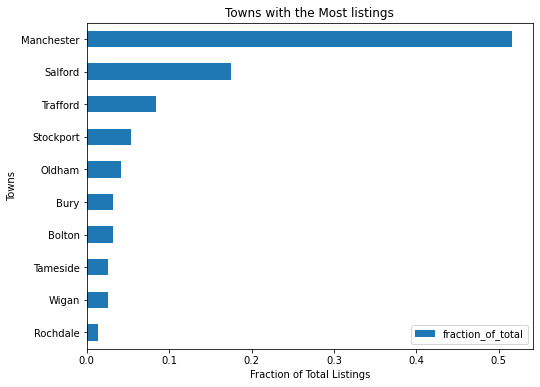

In [37]:
bar_data = gm_df['neighbourhood_group_cleansed'].value_counts().sort_values()

# create new dataframe from bar_data
bar_data = pd.DataFrame(bar_data).reset_index()
bar_data['size'] = bar_data['neighbourhood_group_cleansed']/gm_df['neighbourhood_group_cleansed'].count()

# sort 
bar_data.sort_values(by='size', ascending=False)
bar_data = bar_data.rename(columns={'index' : 'Towns', 'neighbourhood_group_cleansed' : 'number_of_listings',
                        'size':'fraction_of_total'})

#data_new
#plt.figure(figsize=(10,10));
bar_data.plot(kind='barh', x ='Towns', y='fraction_of_total', figsize=(8,6))
plt.title('Towns with the Most listings');
plt.xlabel('Fraction of Total Listings');

From the above chart, we can see that Manchester town has the most listings in the Greater Manchester Area, 
accounting for 53% of total listings followed by Salford with 17% and Trafford with about 9% of total listings. 

#### How does Pricing work for Airbnbs in Manchester?

In [38]:
# mean, #minimum and maximum values
gm_df['price'].mean(), gm_df['price'].min(), gm_df['price'].max()

(143.47600446428572, 8, 7372)

In [39]:
# median
gm_df['price'].median()

79.0

#### What listings did people enjoy the most in the Greater Manchester Area?

In [40]:
ax = gm_df.groupby('property_type').agg(
    median_rating=('review_scores_rating', 'median'),number_of_reviews=('number_of_reviews', 'max')).sort_values(
by='number_of_reviews', ascending=False).reset_index()

ax

,property_type,median_rating,number_of_reviews
0,Entire rental unit,4.663024,1491
1,Private room in rental unit,4.663024,569
2,Private room in bed and breakfast,4.663024,512
3,Tiny home,4.865000,495
4,Entire residential home,4.700000,470
5,Private room in residential home,4.830000,451
6,Room in bed and breakfast,4.766512,438
7,Entire bungalow,4.870000,391
8,Entire cottage,4.900000,383
9,Boat,4.870000,378


Text(0, 0.5, 'Property Type')

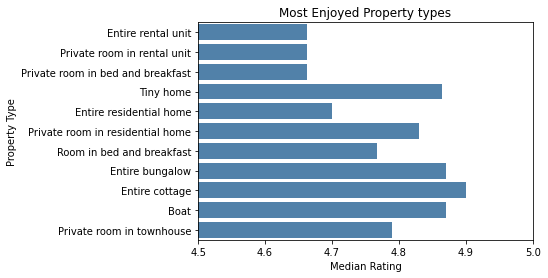

In [41]:
# use the top 10 most reviewed listings
bx = ax.loc[:10]
bx =sb.barplot(data =bx, x='median_rating', y='property_type', color="steelblue", saturation=0.8)
bx.set_xlim(4.5, 5)
plt.title('Most Enjoyed Property types');
plt.xlabel('Median Rating');
plt.ylabel('Property Type')

Amongst the top 10 most reviewed property types. "Entire Cottage" had the highest median rating of 4.9 
followed by entire bungalow, tiny home, private room in a residential home and private room in a 
townhouse. 

#### Pricing Clusters

In [42]:
# Apply a grouper to the price column 
labels = ['$0 - $100', '$100 - $200', '$200 - $300', '$300 - $400', '$400 - $500', '$500 - $1000', '$1000 - $8000']
price_cuts = pd.cut(gm_df['price'], bins = [0, 100, 200, 300, 400, 500, 1000, 8000], right=True, labels= labels)

In [43]:
# create dataframe from the price_cuts
price_clusters = pd.DataFrame(price_cuts).rename(columns={'price': 'price_clusters'})

# concat with the original dataframe
gm_df = pd.concat([gm_df, price_clusters], axis=1)

In [44]:
def price_cluster_plot(df, column, title):
    '''
    This function creates a plot 
    
    INPUT : dataframe, column to be plotted and title of the plot
    
    OUTPUT: Histplot
    
    '''
    
    plt.figure(figsize=(8,6));
    yx = sb.histplot(data = df[column]);
    

    total = float(df[column].count())
    for p in yx.patches:
        width = p.get_width()
        height = p.get_height()
        yx.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
    yx.set_title(title);
    plt.xticks(rotation=90)
    
    return yx

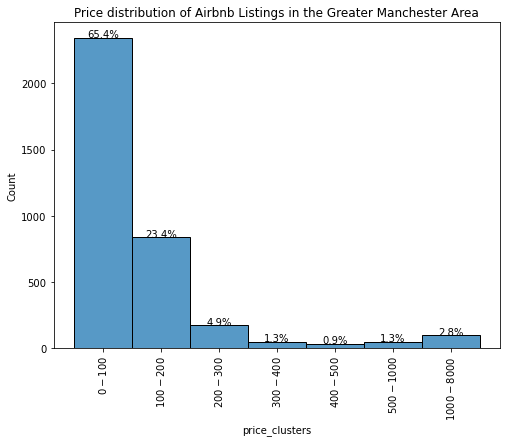

In [45]:
price_cluster_plot(gm_df, column='price_clusters', 
                   title='Price distribution of Airbnb Listings in the Greater Manchester Area');

#### Host Characteristics

In [46]:
(gm_df[gm_df['host_is_superhost']==1]).shape[0]/gm_df.shape[0]

0.2631138392857143

In [47]:
(gm_df[gm_df['host_has_profile_pic']==1]).shape[0]/gm_df.shape[0]

0.9838169642857143

In [48]:
(gm_df[gm_df['host_identity_verified']==1]).shape[0]/gm_df.shape[0]

0.8942522321428571

In [49]:
# host with the most listings
host_df = pd.DataFrame(gm_df['host_name'].value_counts()/gm_df['host_name'].count() *100).reset_index()
host_df = host_df.rename(columns={'index':'name', 'host_name':'perc_count'})
host_df.head(10)

,name,perc_count
0,Miroslav,4.045759
1,Kevin,1.534598
2,David,1.283482
3,John,1.060268
4,Tom,0.920759
5,Alison,0.864955
6,My-Places,0.837054
7,Matt & Steph (City Superhost),0.837054
8,Chris,0.781250
9,Laura,0.753348


In [50]:
host_df['perc_count'].loc[:10].sum()

13.616071428571429

In [51]:
gm_df['room_type'].value_counts()

Entire home/apt    2144
Private room       1397
Shared room          26
Hotel room           17
Name: room_type, dtype: int64

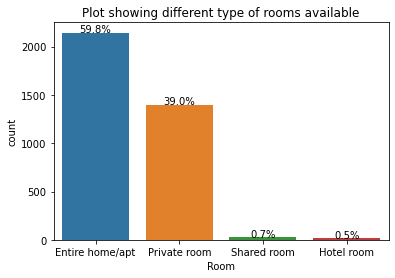

In [52]:
zx = sb.countplot(data=gm_df, x='room_type')

total = float(gm_df['room_type'].count())
for p in zx.patches:
    width = p.get_width()
    height = p.get_height()
    zx.text(p.get_x() + p.get_width()/2.,height+5, '{:1.1f}%'.format((height/total)*100), ha='center')
    zx.set_title('Plot showing different type of rooms available');
    plt.xlabel('Room')

### Machine Learning 

 - Run a regression model to determine if we can predict the prices of airbnb listings

In [53]:
gm_df.head()

,id,scrape_id,last_scraped,name,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_clusters
0,157612,20220324053954,2022-03-24,New attic space/single & Dble room,757016,Margaret,2011-06-29,within a few hours,100%,72%,0,3,3,1,1,Salford,Entire loft,Entire home/apt,3,1 bath,2.0,2.0,36,2,365,2,2,365,365,2.0,365.0,103,7,3,2012-02-13,2022-03-18,4.91,4.92,4.92,4.98,4.93,4.65,4.91,0,1,1,0,0,0.84,$0 - $100
1,283495,20220324053954,2022-03-24,En-suite room in detached house,1476718,Alison,2011-12-06,within a few hours,100%,0%,0,1,1,1,0,Rochdale,Private room in residential home,Private room,2,1 private bath,1.0,1.0,75,3,1125,3,3,1125,1125,3.0,1125.0,10,0,0,2015-04-26,2018-08-05,5.00,5.00,4.90,5.00,5.00,4.80,5.00,0,1,0,1,0,0.12,$0 - $100
2,299194,20220324053954,2022-03-24,Cosy Garden Chalet for all seasons,1542010,Minh,2011-12-28,within an hour,100%,100%,0,1,1,1,1,Stockport,Entire chalet,Entire home/apt,4,1.5 baths,1.0,1.0,50,2,180,2,2,1125,1125,2.0,1125.0,296,26,0,2012-04-08,2022-02-14,4.52,4.67,4.55,4.81,4.85,4.72,4.58,1,1,1,0,0,2.44,$0 - $100
3,310742,20220324053954,2022-03-24,Nice room 10 minutes walk from town,1603652,Francisca,2012-01-13,within a few hours,100%,50%,0,1,1,1,1,Manchester,Private room in rental unit,Private room,1,1 bath,1.0,1.0,34,180,365,180,180,365,365,180.0,365.0,64,0,0,2012-01-31,2018-01-12,4.66,4.75,4.27,4.77,4.86,4.81,4.65,1,1,0,1,0,0.52,$0 - $100
4,332580,20220324053954,2022-03-24,**ELEGANT STAY** CENTRAL MANCHESTER,1694961,Manchester,2012-02-03,within an hour,100%,96%,0,7,7,1,1,Manchester,Private room in rental unit,Private room,2,1 private bath,1.0,1.0,49,2,300,2,2,300,300,2.0,300.0,324,2,0,2012-09-21,2022-01-16,4.85,4.88,4.93,4.94,4.93,4.87,4.81,1,5,4,1,0,2.80,$0 - $100


In [54]:
gm_regression_df = gm_df.copy()

In [55]:
# drop unneeded columns
gm_regression_df = gm_regression_df.drop(columns=['id', 'scrape_id', 'last_scraped', 'name', 'host_id', 
                                      'host_since', 'first_review', 'last_review', 
                                      'price_clusters', 'host_name'])

In [56]:
gm_regression_df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,within a few hours,100%,72%,0,3,3,1,1,Salford,Entire loft,Entire home/apt,3,1 bath,2.0,2.0,36,2,365,2,2,365,365,2.0,365.0,103,7,3,4.91,4.92,4.92,4.98,4.93,4.65,4.91,0,1,1,0,0,0.84
1,within a few hours,100%,0%,0,1,1,1,0,Rochdale,Private room in residential home,Private room,2,1 private bath,1.0,1.0,75,3,1125,3,3,1125,1125,3.0,1125.0,10,0,0,5.00,5.00,4.90,5.00,5.00,4.80,5.00,0,1,0,1,0,0.12
2,within an hour,100%,100%,0,1,1,1,1,Stockport,Entire chalet,Entire home/apt,4,1.5 baths,1.0,1.0,50,2,180,2,2,1125,1125,2.0,1125.0,296,26,0,4.52,4.67,4.55,4.81,4.85,4.72,4.58,1,1,1,0,0,2.44
3,within a few hours,100%,50%,0,1,1,1,1,Manchester,Private room in rental unit,Private room,1,1 bath,1.0,1.0,34,180,365,180,180,365,365,180.0,365.0,64,0,0,4.66,4.75,4.27,4.77,4.86,4.81,4.65,1,1,0,1,0,0.52
4,within an hour,100%,96%,0,7,7,1,1,Manchester,Private room in rental unit,Private room,2,1 private bath,1.0,1.0,49,2,300,2,2,300,300,2.0,300.0,324,2,0,4.85,4.88,4.93,4.94,4.93,4.87,4.81,1,5,4,1,0,2.80


In [57]:
# remove the percentage in some columns and convert to numeric datatypes
gm_regression_df['host_response_rate'] =  gm_regression_df['host_response_rate'].str.replace("%", "")

gm_regression_df['host_acceptance_rate'] =  gm_regression_df['host_acceptance_rate'].str.replace("%", "")
   
# convert to int
gm_regression_df['host_response_rate'] = pd.to_numeric(gm_regression_df['host_response_rate']).astype(int)
gm_regression_df['host_acceptance_rate'] =  pd.to_numeric(gm_regression_df['host_acceptance_rate']).astype(int)

In [58]:
gm_regression_df['host_response_rate'].head()

0    100
1    100
2    100
3    100
4    100
Name: host_response_rate, dtype: int64

In [59]:
# check the bathrooms_text column
gm_regression_df['bathrooms_text'].value_counts()

1 bath               1331
1 shared bath         483
2 baths               481
1 private bath        364
1.5 baths             310
1.5 shared baths      208
2.5 baths             115
3 baths                65
2 shared baths         61
Shared half-bath       25
2.5 shared baths       24
4 baths                18
3 shared baths         18
3.5 baths              14
0 baths                12
4.5 baths               7
Half-bath               7
3.5 shared baths        7
Private half-bath       6
4 shared baths          6
5 baths                 6
0 shared baths          6
5.5 baths               4
6 baths                 3
6.5 baths               1
27 shared baths         1
5 shared baths          1
Name: bathrooms_text, dtype: int64

In [60]:
def split_bathroom(df, column, text, new_column):
    '''
    This function creates a new column from an existing column based on whether a pattern or regex is contained in the string
    
    INPUT : dataframe, column, text and new column
    
    OUTPUT: dataframe with new column
    
    '''
    
    df_2 = df[df[column].str.contains(text, case=False)]
    
    df.loc[df[column].str.contains(text, case=False), new_column] = df_2[column]
      
    return df

In [61]:
gm_regression_df = split_bathroom(gm_regression_df, column='bathrooms_text', text='shared', new_column='shared_bath')
gm_regression_df = split_bathroom(gm_regression_df, column='bathrooms_text', text='private', new_column='private_bath')

In [62]:
gm_regression_df['shared_bath'].value_counts()

1 shared bath       483
1.5 shared baths    208
2 shared baths       61
Shared half-bath     25
2.5 shared baths     24
3 shared baths       18
3.5 shared baths      7
0 shared baths        6
4 shared baths        6
27 shared baths       1
5 shared baths        1
Name: shared_bath, dtype: int64

In [63]:
gm_regression_df['private_bath'].value_counts()

1 private bath       364
Private half-bath      6
Name: private_bath, dtype: int64

In [64]:
gm_regression_df['bathrooms_text'] =  gm_regression_df['bathrooms_text'].str.replace("private bath", "pb", case=False)
gm_regression_df['bathrooms_text'] =  gm_regression_df['bathrooms_text'].str.replace("private baths", "pbs", case=False)
gm_regression_df['bathrooms_text'] =  gm_regression_df['bathrooms_text'].str.replace("shared bath", "sb", case=False)
gm_regression_df['bathrooms_text'] =  gm_regression_df['bathrooms_text'].str.replace("shared baths", "sb", case=False)
gm_regression_df['bathrooms_text'] =  gm_regression_df['bathrooms_text'].str.replace("shared half-bath", "sb", case=False)
gm_regression_df['bathrooms_text'] =  gm_regression_df['bathrooms_text'].str.replace("private half-bath", "sb", case=False)

In [65]:
# new column for only 'bathrooms', not private or shared
gm_regression_df = split_bathroom(gm_regression_df, column='bathrooms_text', text='bath', new_column='bathrooms_new')

In [66]:
gm_regression_df['shared_bath'] = gm_regression_df['shared_bath'].str.split(" ", expand=True)
gm_regression_df['private_bath'] = gm_regression_df['private_bath'].str.split(" ", expand=True)
gm_regression_df['bathrooms_new'] = gm_regression_df['bathrooms_new'].str.split(" ", expand=True)

In [67]:
# fill up NaNs with 0 
gm_regression_df = gm_regression_df.fillna(0)

In [68]:
gm_regression_df['bathrooms_new'].value_counts()

1            1331
0            1210
2             481
1.5           310
2.5           115
3              65
4              18
3.5            14
0              12
4.5             7
Half-bath       7
5               6
5.5             4
6               3
6.5             1
Name: bathrooms_new, dtype: int64

In [69]:
gm_regression_df['shared_bath'] = gm_regression_df['shared_bath'].replace(to_replace='Shared', value=0.5)
gm_regression_df['private_bath'] = gm_regression_df['private_bath'].replace(to_replace='Private', value=0.5)
gm_regression_df['bathrooms_new'] = gm_regression_df['bathrooms_new'].replace(to_replace='Half-bath', value=0.5)

In [70]:
# convert to numeric

gm_regression_df['shared_bath'] = pd.to_numeric(gm_regression_df['shared_bath']).astype(int)
gm_regression_df['private_bath'] = pd.to_numeric(gm_regression_df['private_bath']).astype(int)
gm_regression_df['bathrooms_new'] =  pd.to_numeric(gm_regression_df['bathrooms_new']).astype(int)

In [71]:
gm_regression_df[['shared_bath', 'private_bath', 'bathrooms_new']].head()

,shared_bath,private_bath,bathrooms_new
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,1,0


In [72]:
# drop original bathrooms_text columns
gm_regression_df = gm_regression_df.drop(columns=['bathrooms_text'])

In [73]:
def encoder(df):
    '''
    This function encodes the categorical columns;'neighbourhood_group_cleansed' and 'property_type'.  
    
    INPUT : dataframe for the ML model
    
    OUTPUT: dataframe with encoded columns 
    
    '''
    
    for column in df[['neighbourhood_group_cleansed', 'property_type']].columns:

        labels = df[column].astype('category').cat.categories.tolist()
    
        replace_map = {column : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    
        df.replace(replace_map, inplace=True)
        
        print(replace_map)
    
    
    return df 

In [74]:
gm_regression_df = encoder(gm_regression_df)

{'neighbourhood_group_cleansed': {'Bolton': 1, 'Bury': 2, 'Manchester': 3, 'Oldham': 4, 'Rochdale': 5, 'Salford': 6, 'Stockport': 7, 'Tameside': 8, 'Trafford': 9, 'Wigan': 10}}
{'property_type': {'Barn': 1, 'Boat': 2, 'Camper/RV': 3, 'Campsite': 4, 'Domed home': 5, 'Entire bungalow': 6, 'Entire cabin': 7, 'Entire chalet': 8, 'Entire condominium (condo)': 9, 'Entire cottage': 10, 'Entire guest suite': 11, 'Entire guesthouse': 12, 'Entire loft': 13, 'Entire place': 14, 'Entire rental unit': 15, 'Entire residential home': 16, 'Entire serviced apartment': 17, 'Entire townhouse': 18, 'Entire vacation home': 19, 'Entire villa': 20, 'Farm stay': 21, 'Houseboat': 22, 'Private room': 23, 'Private room in barn': 24, 'Private room in bed and breakfast': 25, 'Private room in bungalow': 26, 'Private room in cabin': 27, 'Private room in campsite': 28, 'Private room in casa particular': 29, 'Private room in condominium (condo)': 30, 'Private room in cottage': 31, 'Private room in farm stay': 32, 'Pri

In [75]:
host_dummy = pd.get_dummies(gm_regression_df['host_response_time'], prefix='host_response')
room_dummy = pd.get_dummies(gm_regression_df['room_type'], prefix='room_type')

# concat the main df and dummies
gm_regression_df = pd.concat([gm_regression_df, host_dummy, room_dummy], axis=1)

In [76]:
# drop the columns we have created dummies for
gm_regression_df = gm_regression_df.drop(columns=['host_response_time', 'room_type'], axis=1)

In [77]:
# Work on the amenities column
df_amenities.head()

,2 plate induction hob induction stove,\u2018Ruark\u2019 deluxe Bluetooth radio Bluetooth sound system,100\ HDTV with Chromecast,18\ HDTV,2-5 years old,23\ HDTV with standard cable,24\ HDTV,24\ HDTV with standard cable,26\ HDTV with standard cable,28\ TV with,32\ HDTV,32\ HDTV with Amazon Prime Video,32\ HDTV with Apple TV,32\ HDTV with Chromecast,32\ HDTV with Netflix,32\ HDTV with premium cable,32\ HDTV with standard cable,32\ TV,32\ TV with Amazon Prime Video,32\ TV with Netflix,32\ TV with standard cable,36\ HDTV with Netflix,37\ HDTV with Amazon Prime Video,37\ HDTV with Roku,38\ HDTV with Amazon Prime Video,38\ HDTV with Netflix,38\ TV,39\ HDTV,40\ HDTV,40\ HDTV with Amazon Prime Video,40\ HDTV with Netflix,40\ HDTV with premium cable,40\ HDTV with standard cable,40\ TV,42\ HDTV,42\ HDTV with Amazon Prime Video,42\ HDTV with Apple TV,42\ HDTV with Netflix,42\ HDTV with standard cable,42\ TV,43\ HDTV,43\ HDTV with,43\ HDTV with Amazon Prime Video,43\ HDTV with HBO Max,43\ HDTV with Netflix,43\ HDTV with premium cable,43\ HDTV with standard cable,43\ TV,44\ HDTV with Netflix,44\ TV,45\ HDTV,45\ TV with Netflix,46\ HDTV with Amazon Prime Video,46\ HDTV with Netflix,47\ HDTV with standard cable,48\ HDTV with Apple TV,49\ HDTV,49\ HDTV with Netflix,5-10 years old,50\ HDTV,50\ HDTV with Amazon Prime Video,50\ HDTV with Netflix,50\ HDTV with Roku,50\ TV,50\ TV with Amazon Prime Video,50\ TV with Netflix,50\ TV with standard cable,52\ HDTV with Amazon Prime Video,52\ HDTV with Netflix,52\ HDTV with standard cable,55\ HDTV,55\ HDTV with Amazon Prime Video,55\ HDTV with Apple TV,55\ HDTV with Chromecast,55\ HDTV with Netflix,55\ HDTV with premium cable,55\ HDTV with standard cable,55\ TV with Netflix,58\ HDTV with Amazon Prime Video,58\ HDTV with Apple TV,60\ HDTV with Netflix,60\ TV with Netflix,65\ HDTV,65\ HDTV with Amazon Prime Video,65\ HDTV with Netflix,65\ HDTV with premium cable,75\ HDTV with Netflix,75\ HDTV with standard cable,A hot shower and sink is in the bathroom body soap,AEG refrigerator,AGA + 4 burner electric cooker gas stove,Air conditioning,Aiwa bass sound shatem Bluetooth sound system,Aldi shampoo,Alto amp sound system with aux,Amazon Alexa sound system,Amazon Alexa Dot Bluetooth sound system,Amazon Echo + Google Home Bluetooth sound system,Amazon Echo Bluetooth sound system,Amazon Prime Video,American Style Fridge Freezer refrigerator,American Style Side by Side Fridge Freezer refrigerator,Any body soap,Any conditioner,Anyah body soap,Anyah conditioner,Anyah shampoo,Apple TV,Arbonne body soap,Arbonne shampoo,At request shampoo,Aveda conditioner,Avtex sound system with aux,BBQ grill,Baby Shampoo shampoo,Baby bath,Baby monitor,Baby safety gates,Babysitter recommendations,Backyard,Baking sheet,Barbecue utensils,Bathroom essentials,Bathtub,Beach essentials,Beachfront,Beco refrigerator,Bed linens,Bedroom comforts,Beko electric stove,Beko refrigerator,Beko stainless steel oven,Bidet,Bikes,Bluetooth sound system,Board games,Boat slip,Body wash body soap,Body Shop conditioner,Body Shop shampoo,Body soap,Body wash and bar of soap supplied body soap,Bosch oven,Bosch refrigerator,Bosch electric stove,Bosch fridge with ice box refrigerator,Bosch oven,Bosch refrigerator,Bosch stainless steel gas stove,Bosch stove,Bose Bluetooth sound system,Bose / Wonderboom Bluetooth sound system,Bose sound system with Bluetooth and aux,Bose sound system with aux,Breakfast,Britannia stainless steel gas stove,Britannia stainless steel oven,Brittanica electric stove,Building staff,Busch refrigerator,Bush Sound Bar sound system,CDA refrigerator,CERAMIC 2 RING stove,CHI a tiny fridge for milk butter etc \u2026 only tiny refrigerator,Cable TV,Can make space available for longer stays. refrigerator,Candy - Electric Fan Assisted stainless steel oven,Candy - fan electric stainless steel oven,Candy stainless steel oven,Carbon monoxide alarm,Ceiling fan,Central air conditioning,Central heating,Changing table,Children\u2019s books and toys,Children

- There are a lot of repititions in the dataframe, so sort dataframe by frequency of occurence 

In [78]:
df_3 = pd.DataFrame(df_amenities.sum())
df_3.columns = ['counts']
df_3 = df_3.sort_values(by='counts', ascending=False).reset_index().rename(columns={'index':'amenities'})
df_3

,amenities,counts
0,Wifi,3265
1,Long term stays allowed,3237
2,Smoke alarm,3123
3,Essentials,3019
4,Iron,2741
5,Hangers,2736
6,Heating,2726
7,Hot water,2712
8,Hair dryer,2412
9,Kitchen,2376


- Take the first 100 amenities as these give a full representation of the amenities in all listings

In [79]:
features = df_3['amenities'][:150].to_list()

In [80]:
features

[' Wifi',
 ' Long term stays allowed',
 ' Smoke alarm',
 ' Essentials',
 ' Iron',
 ' Hangers',
 ' Heating',
 ' Hot water',
 ' Hair dryer',
 'Kitchen',
 ' Washer',
 ' Dishes and silverware',
 ' Carbon monoxide alarm',
 ' Refrigerator',
 ' Dedicated workspace',
 ' Microwave',
 ' Shampoo',
 ' Bed linens',
 ' Cooking basics',
 ' Free parking on premises',
 ' Oven',
 ' TV',
 ' First aid kit',
 ' Free street parking',
 ' Stove',
 ' Fire extinguisher',
 ' Private entrance',
 ' Hot water kettle',
 ' Bathtub',
 ' Dryer',
 ' Extra pillows and blankets',
 ' Toaster',
 ' Freezer',
 ' Shower gel',
 ' Cleaning products',
 ' Dishwasher',
 ' Dining table',
 ' Luggage dropoff allowed',
 ' Lockbox',
 ' Coffee maker',
 ' Wine glasses',
 ' Kitchen',
 ' Body soap',
 ' Security cameras on property',
 ' Drying rack for clothing',
 ' Backyard',
 ' Lock on bedroom door',
 ' Elevator',
 ' Host greets you',
 ' Room-darkening shades',
 ' Outdoor furniture',
 'TV',
 ' Central heating',
 ' Breakfast',
 ' Conditione

In [81]:
amenities_updated = df_amenities.filter(items=(features))
amenities_updated.head()

,Wifi,Long term stays allowed,Smoke alarm,Essentials,Iron,Hangers,Heating,Hot water,Hair dryer,Kitchen,Washer,Dishes and silverware,Carbon monoxide alarm,Refrigerator,Dedicated workspace,Microwave,Shampoo,Bed linens,Cooking basics,Free parking on premises,Oven,TV,First aid kit,Free street parking,Stove,Fire extinguisher,Private entrance,Hot water kettle,Bathtub,Dryer,Extra pillows and blankets,Toaster,Freezer,Shower gel,Cleaning products,Dishwasher,Dining table,Luggage dropoff allowed,Lockbox,Coffee maker,Wine glasses,Kitchen,Body soap,Security cameras on property,Drying rack for clothing,Backyard,Lock on bedroom door,Elevator,Host greets you,Room-darkening shades,Outdoor furniture,TV,Central heating,Breakfast,Conditioner,Indoor fireplace,Ethernet connection,Outdoor dining area,Patio or balcony,Pack \u2019n play/Travel crib,Cable TV,Private patio or balcony,Baking sheet,Single level home,Clothing storage,Private fenced garden or backyard,Laundromat nearby,TV with standard cable,Portable fans,Cleaning before checkout,High chair,Clothing storage: closet,Crib,BBQ grill,Paid parking off premises,Cooking basics,Free washer \u2013 In unit,Air conditioning,Gym,Free dryer \u2013 In unit,Mini fridge,Stainless steel oven,Keypad,Board games,Clothing storage: dresser and closet,Children\u2019s books and toys,Clothing storage: closet and dresser,Barbecue utensils,Building staff,Hot tub,Nespresso machine,Smart lock,Paid parking lot off premises,Security cameras on property,Rice maker,Radiant heating,Shared patio or balcony,Paid parking on premises,Children\u2019s dinnerware,Free washer \u2013 In building,Netflix,Fire pit,Fire extinguisher,Electric stove,Pool,Free dryer \u2013 In building,Safe,Waterfront,Babysitter recommendations,EV charger,Shared fenced garden or backyard,Sound system,Portable heater,Clothing storage: wardrobe,Baby bath,Clothing storage: dresser,Lake access,Baby safety gates,Pocket wifi,Private garden or backyard,Dedicated workspace: table,Window guards,Sauna,Outlet covers,Shared garden or backyard,Paid street parking off premises,Gas stove,Wifi,Wine glasses,Shampoo,Game console,standard cable,Bidet,Trash compactor,HDTV,Free driveway parking on premises \u2013 1 space,Paid parking garage off premises,Piano,Paid parking on premises,HDTV with Netflix,Pour-over coffee,dresser,Paid dryer \u2013 In building,Free dryer,Paid washer \u2013 In building,Dedicated workspace: desk,Fireplace guards,Free washer,Private hot tub,and dresser
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,0,1,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Concat the gm_regression_df with the ameneties_updated column 

In [82]:
gm_regression_df = pd.concat([gm_regression_df, amenities_updated], axis=1)

In [83]:
gm_regression_df.shape

(3584, 198)

#### There are 198 columns in this dataframe and so feature engineering and selection is important to create a working machine learning model 

- use VIF to select features to include in the model

In [84]:
# drop the target variable
vif_model = gm_regression_df.drop(['price'], axis=1)

In [85]:
vif_df = pd.DataFrame()
vif_df['feature'] = vif_model.columns
vif_df['VIF'] = [variance_inflation_factor(vif_model.values, i) for i in range(len(vif_model.columns))]
vif_df.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,host_response_rate,4.688562
1,host_acceptance_rate,1.870903
2,host_is_superhost,1.572272
3,host_listings_count,inf
4,host_total_listings_count,inf


In [86]:
vif_df_new = vif_df[vif_df['VIF']<=10]
vif_df_new.shape

(175, 2)

In [87]:
feature_list =  vif_df_new['feature'].to_list()
feature_list[:10]

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_group_cleansed',
 'accommodates',
 'bedrooms',
 'beds',
 'minimum_nights']

In [88]:
model_df = gm_regression_df.filter(items=(feature_list))
model_df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,accommodates,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count_shared_rooms,reviews_per_month,shared_bath,private_bath,bathrooms_new,Wifi,Long term stays allowed,Smoke alarm,Essentials,Iron,Hangers,Heating,Hot water,Hair dryer,Kitchen,Washer,Dishes and silverware,Carbon monoxide alarm,Refrigerator,Dedicated workspace,Microwave,Shampoo,Bed linens,Cooking basics,Free parking on premises,Oven,TV,First aid kit,Free street parking,Stove,Fire extinguisher,Private entrance,Hot water kettle,Bathtub,Dryer,Extra pillows and blankets,Toaster,Freezer,Shower gel,Cleaning products,Dishwasher,Dining table,Luggage dropoff allowed,Lockbox,Coffee maker,Wine glasses,Kitchen,Body soap,Security cameras on property,Drying rack for clothing,Backyard,Lock on bedroom door,Elevator,Host greets you,Room-darkening shades,Outdoor furniture,TV,Central heating,Breakfast,Conditioner,Indoor fireplace,Ethernet connection,Outdoor dining area,Patio or balcony,Pack \u2019n play/Travel crib,Private patio or balcony,Baking sheet,Single level home,Clothing storage,Private fenced garden or backyard,Laundromat nearby,Portable fans,Cleaning before checkout,High chair,Clothing storage: closet,Crib,BBQ grill,Paid parking off premises,Cooking basics,Free washer \u2013 In unit,Air conditioning,Gym,Free dryer \u2013 In unit,Mini fridge,Stainless steel oven,Keypad,Board games,Clothing storage: dresser and closet,Children\u2019s books and toys,Clothing storage: closet and dresser,Barbecue utensils,Building staff,Hot tub,Nespresso machine,Smart lock,Paid parking lot off premises,Security cameras on property,Rice maker,Radiant heating,Shared patio or balcony,Paid parking on premises,Children\u2019s dinnerware,Free washer \u2013 In building,Netflix,Fire pit,Fire extinguisher,Electric stove,Pool,Free dryer \u2013 In building,Safe,Waterfront,Babysitter recommendations,EV charger,Shared fenced garden or backyard,Sound system,Portable heater,Clothing storage: wardrobe,Baby bath,Clothing storage: dresser,Lake access,Baby safety gates,Pocket wifi,Private garden or backyard,Dedicated workspace: table,Window guards,Sauna,Outlet covers,Shared garden or backyard,Paid street parking off premises,Gas stove,Wifi,Wine glasses,Shampoo,Game console,standard cable,Bidet,Trash compactor,HDTV,Free driveway parking on premises \u2013 1 space,Paid parking garage off premises,Piano,Paid parking on premises,HDTV with Netflix,Pour-over coffee,dresser,Paid dryer \u2013 In building,Free dryer,Paid washer \u2013 In building,Dedicated workspace: desk,Fireplace guards,Free washer,Private hot tub,and dresser
0,100,72,0,1,1,6,3,2.0,2.0,2,365,103,7,3,4.91,4.92,4.92,4.98,4.93,4.65,4.91,0,0,0.84,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100,0,0,1,0,5,2,1.0,1.0,3,1125,10,0,0,5.00,5.00,4.90,5.00,5.00,4.80,5.00,0,0,0.12,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100,100,0,1,1,7,4,1.0,1.0,2,180,296,26,0,4.52,4.67,4.55,4.81,4.85,4.72,4.58,1,0,2.44,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,0,1,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0

In [89]:
price_col = gm_regression_df['price']

In [90]:
# add price column back to model_df
model_df = model_df.join(price_col)

In [91]:
model_df['price'].head()

0    36
1    75
2    50
3    34
4    49
Name: price, dtype: int64

In [92]:
def linear_reg(df, test_size=0.3, random_state=42):
    '''
    This function uses linear regression to train a machine learning model and predict on test data
    
    INPUT: dataframe
    
    OUTPUT: feature importance, root mean square error and R-squared
    
    '''
    
    X = df.drop(columns=['price'])
    y = df[['price']]
    X_columns = X.columns
    
    
    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)
    
    
        
    clf = LinearRegression()
    
  
                      
    parameters = {
                  'n_jobs': [1, 2, 5, 10, 100],
                  'fit_intercept': [True, False]
                 
                  }
    
        
    cv = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, verbose=3)  
    
    # fit the gridSearch
    cv.fit(X_train,y_train)
    
    # predict on the test data
    pred = cv.predict(X_test)
    
    # score the model 
    r2 = r2_score(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = mse **.5
    
     
    # find the best parameters
    best_par = cv.best_params_
    
    # get coefficients
    coefficients = cv.best_estimator_.coef_
        
    #feature importance
    importance = np.abs(coefficients)
    feature_importance = pd.DataFrame(importance, columns=X_columns).T
    #feature_importance = feature_importance.T
    feature_importance.columns = ['importance']
    feature_importance = feature_importance.sort_values('importance', ascending=False)
                                      #columns=['importance']).sort_values('importance', ascending=False)
    
   
    
    
    print("The model performance for testing set")
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print("\n")

    
    return feature_importance, rmse, r2
    

In [93]:
linear_feat_importance, linear_rmse, linear_r2 = linear_reg(model_df)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ...................fit_intercept=True, n_jobs=1; total time=   0.0s
[CV 2/3] END ...................fit_intercept=True, n_jobs=1; total time=   0.0s
[CV 3/3] END ...................fit_intercept=True, n_jobs=1; total time=   0.0s
[CV 1/3] END ...................fit_intercept=True, n_jobs=2; total time=   0.0s
[CV 2/3] END ...................fit_intercept=True, n_jobs=2; total time=   0.0s
[CV 3/3] END ...................fit_intercept=True, n_jobs=2; total time=   0.0s
[CV 1/3] END ...................fit_intercept=True, n_jobs=5; total time=   0.0s
[CV 2/3] END ...................fit_intercept=True, n_jobs=5; total time=   0.0s
[CV 3/3] END ...................fit_intercept=True, n_jobs=5; total time=   0.0s
[CV 1/3] END ..................fit_intercept=True, n_jobs=10; total time=   0.1s
[CV 2/3] END ..................fit_intercept=True, n_jobs=10; total time=   0.0s
[CV 3/3] END ..................fit_intercept=Tru

In [94]:
linear_feat_importance

,importance
Kitchen,207.488189
Wifi,145.428124
Essentials,145.366223
Wine glasses,117.868674
Fire extinguisher,116.904320
Heating,115.691930
Kitchen,99.738268
Central heating,92.921298
Free washer \u2013 In building,89.352854
Smoke alarm,85.933382


In [95]:
# random forest regression
def random_forest(df):
    '''
    This function uses randomforestregression to train a machine learning model and predict on test data
    
    INPUT: dataframe
    
    OUTPUT: root mean square error, R-squared and best parameters
    
    '''
    
    X = df.drop(['price'], axis=1)
    X_columns = X.columns
    
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.fit_transform(X_test)
        
    clf = RandomForestRegressor()
    
    
    parameters = {

                'n_estimators': [50, 100, 200, 300, 400],
                'max_depth': [2, 3, 4, 5],
                 'max_depth': [80, 90, 100]
        
                     }
    cv = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, verbose=3)
    
    #clf.fit(X_train, y_train)
    
    model = cv
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    #best_params = model.best_params_
    mse = mean_squared_error(y_test, pred)
    rmse = mse**.5
    r2 = r2_score(y_test, pred)
   
      
    # find the best parameters
    best_par = model.best_params_
    

    # feature importance using permutation importance
    r = permutation_importance(model, X_test, y_test,
                           n_repeats=10,
                           random_state=0)
    perm = pd.DataFrame(columns=['AVG_Importance'], index=[i for i in X_train.columns])
    perm['AVG_Importance'] = r.importances_mean
    perm = perm.sort_values(by='AVG_Importance', ascending=False);
    
    
    
    return rmse, r2, best_par, perm

In [97]:
r_forest_rmse, r_forest_r2, r_fores_best_params, r_forest_importance = random_forest(model_df)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ..................max_depth=80, n_estimators=50; total time=   2.0s
[CV 2/5] END ..................max_depth=80, n_estimators=50; total time=   1.9s
[CV 3/5] END ..................max_depth=80, n_estimators=50; total time=   2.0s
[CV 4/5] END ..................max_depth=80, n_estimators=50; total time=   1.9s
[CV 5/5] END ..................max_depth=80, n_estimators=50; total time=   1.9s
[CV 1/5] END .................max_depth=80, n_estimators=100; total time=   3.8s
[CV 2/5] END .................max_depth=80, n_estimators=100; total time=   3.8s
[CV 3/5] END .................max_depth=80, n_estimators=100; total time=   3.9s
[CV 4/5] END .................max_depth=80, n_estimators=100; total time=   3.8s
[CV 5/5] END .................max_depth=80, n_estimators=100; total time=   3.8s
[CV 1/5] END .................max_depth=80, n_estimators=200; total time=   7.5s
[CV 2/5] END .................max_depth=80, n_es

In [98]:
r_forest_rmse, r_forest_r2

(205.36552075750245, 0.48977270101447745)

In [99]:
def lasso_new(df):
    '''
    This function uses lasso regression to train a machine learning model and predict on test data
    
    INPUT: dataframe
    
    OUTPUT: R-squared, root mean square error, best parameters, feature importance
    
    '''
    
    X = df.drop(columns=['price'])
    y = df['price']
    X_columns = X.columns

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
                      ])


    search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,1,0.2)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )
    # fit the gridSearch
    search.fit(X_train,y_train)
    
    # predict on the test data
    pred = search.predict(X_test)
    
    # score the model 
    r2 = r2_score(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = mse**.5
    
    # find the best parameters
    best_par = search.best_params_
    
    # get coefficients
    coefficients = search.best_estimator_.named_steps['model'].coef_
        
    #feature importance
    importance = np.abs(coefficients)
    feature_importance = pd.DataFrame(importance, index= X_columns,
                                      columns=['importance']).sort_values('importance', ascending=False)[:10]
   
        
    #print("R2:{1:.3f}, rmse:{0:.6f}, MSE:{2:.2f}".format(r2, rmse, mse))
    
    return r2, rmse, best_par, feature_importance

In [100]:
lasso_r2, lasso_rmse, lasso_best_par, lasso_feature_importance = lasso_new(model_df)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...............................model__alpha=0.1; total time=   0.3s
[CV 2/5] END ...............................model__alpha=0.1; total time=   0.2s
[CV 3/5] END ...............................model__alpha=0.1; total time=   0.1s
[CV 4/5] END ...............................model__alpha=0.1; total time=   0.1s
[CV 5/5] END ...............................model__alpha=0.1; total time=   0.1s
[CV 1/5] END ...............model__alpha=0.30000000000000004; total time=   0.1s
[CV 2/5] END ...............model__alpha=0.30000000000000004; total time=   0.1s
[CV 3/5] END ...............model__alpha=0.30000000000000004; total time=   0.1s
[CV 4/5] END ...............model__alpha=0.30000000000000004; total time=   0.1s
[CV 5/5] END ...............model__alpha=0.30000000000000004; total time=   0.1s
[CV 1/5] END ................model__alpha=0.5000000000000001; total time=   0.1s
[CV 2/5] END ................model__alpha=0.50000

In [101]:
lasso_r2, lasso_rmse, lasso_feature_importance

(0.1981674091418255,
 257.44682332231986,
                    importance
 Kitchen             80.483713
  Essentials         49.567864
  Heating            41.324422
 accommodates        31.173240
  Kitchen            29.889606
  Washer             29.018937
  Hot water          28.275337
  Smoke alarm        27.707485
 reviews_per_month   26.370313
  Central heating    23.238730)

In [102]:
def XGBboost(df):
    '''
    This function uses GradientBoostingRegression to train a machine learning model and predict on test data
    
    INPUT: dataframe
    
    OUTPUT: R-squared, root mean square error, best parameters, feature importance
    
    '''
    
    X = df.drop(['price'], axis=1)
    Y = df['price']
    X_columns = X.columns

    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
    

        
    clf = GradientBoostingRegressor()
    
    
    parameters = {

                'learning_rate': [0.1, 0.5, 1],
                'min_samples_leaf': [10, 20, 40 , 60]
                
        
                     }
    cv = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, verbose=3)
    
    model = cv
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    r2 = r2_score(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = mse**.5
        
    coefficients = model.best_estimator_.feature_importances_
        
    #feature importance
    importance = np.abs(coefficients)
    feature_importance = pd.DataFrame(importance, index= X_columns,
                                      columns=['importance']).sort_values('importance', ascending=False)[:10]
    
    return r2, mse, rmse, feature_importance

In [103]:
XGB_r2, XGB_mse, XGB_rmse, XGB_feature_importance = XGBboost(model_df)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .........learning_rate=0.1, min_samples_leaf=10; total time=   1.0s
[CV 2/5] END .........learning_rate=0.1, min_samples_leaf=10; total time=   0.8s
[CV 3/5] END .........learning_rate=0.1, min_samples_leaf=10; total time=   0.8s
[CV 4/5] END .........learning_rate=0.1, min_samples_leaf=10; total time=   0.8s
[CV 5/5] END .........learning_rate=0.1, min_samples_leaf=10; total time=   0.8s
[CV 1/5] END .........learning_rate=0.1, min_samples_leaf=20; total time=   0.8s
[CV 2/5] END .........learning_rate=0.1, min_samples_leaf=20; total time=   0.8s
[CV 3/5] END .........learning_rate=0.1, min_samples_leaf=20; total time=   0.8s
[CV 4/5] END .........learning_rate=0.1, min_samples_leaf=20; total time=   0.8s
[CV 5/5] END .........learning_rate=0.1, min_samples_leaf=20; total time=   0.8s
[CV 1/5] END .........learning_rate=0.1, min_samples_leaf=40; total time=   0.9s
[CV 2/5] END .........learning_rate=0.1, min_sam

In [104]:
XGB_r2, XGB_rmse

(0.5018373889523006, 202.92298851145608)

- The best performing model has a root-mean-sqaure-error of 202 which is high
- Can we improve model performane by removing outliers in the dataset?

### Outlier Removal 

- Using Interquartile range to determine outliers 

In [105]:
q3, q1 = np.percentile(model_df['price'], [75, 25])
iqr = q3 - q1
q3 + (iqr*1.5)

245.0

- Therefore any values above $245 are deemed as outliers and discared. 

In [113]:
new_model_df = model_df[model_df['price']<245]

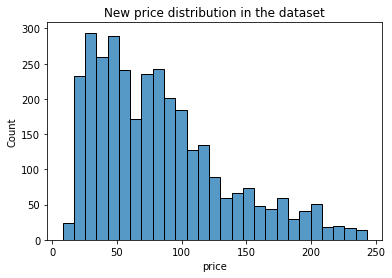

In [140]:
sb.histplot(new_model_df['price']);
plt.title('New price distribution in the dataset');

Re-run the machine learning models new data

In [108]:
linear_feat_importance, linear_rmse, linear_r2 = linear_reg(new_model_df)
r_forest_rmse, r_forest_r2, r_fores_best_params, r_forest_importance = random_forest(new_model_df)
lasso_r2, lasso_rmse, lasso_best_par, lasso_feature_importance = lasso_new(new_model_df)
XGB_r2, XGB_mse, XGB_rmse, XGB_feature_importance = XGBboost(new_model_df)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ...................fit_intercept=True, n_jobs=1; total time=   0.1s
[CV 2/3] END ...................fit_intercept=True, n_jobs=1; total time=   0.1s
[CV 3/3] END ...................fit_intercept=True, n_jobs=1; total time=   0.1s
[CV 1/3] END ...................fit_intercept=True, n_jobs=2; total time=   0.1s
[CV 2/3] END ...................fit_intercept=True, n_jobs=2; total time=   0.1s
[CV 3/3] END ...................fit_intercept=True, n_jobs=2; total time=   0.1s
[CV 1/3] END ...................fit_intercept=True, n_jobs=5; total time=   0.1s
[CV 2/3] END ...................fit_intercept=True, n_jobs=5; total time=   0.1s
[CV 3/3] END ...................fit_intercept=True, n_jobs=5; total time=   0.1s
[CV 1/3] END ..................fit_intercept=True, n_jobs=10; total time=   0.0s
[CV 2/3] END ..................fit_intercept=True, n_jobs=10; total time=   0.1s
[CV 3/3] END ..................fit_intercept=Tru

In [109]:
# create a dataframe of r2 and rmse values
results = {'Regression Algorithms': ['Linear Regression', 'RandomForestRegression', 'Lasso Regression', 'GradientBoostingRegression'], 
           'R2': [linear_r2, r_forest_r2, lasso_r2, XGB_r2], 
           'RMSE': [linear_rmse, r_forest_rmse, lasso_rmse, XGB_rmse]}
results_df = pd.DataFrame(results)

In [110]:
results_df

,Regression Algorithms,R2,RMSE
0,Linear Regression,0.508018,35.287716
1,RandomForestRegression,0.593294,32.229524
2,Lasso Regression,0.513641,35.244554
3,GradientBoostingRegression,0.571920,33.065569


In [129]:
# feature importance
r_feature_importance = r_forest_importance.reset_index()
r_feature_importance = r_feature_importance.rename(columns={'index':'Feature'})
r_feature_importance[:15]

,Feature,AVG_Importance
0,accommodates,0.545746
1,bathrooms_new,0.163491
2,minimum_nights,0.029080
3,number_of_reviews,0.022886
4,Free street parking,0.019769
5,Gym,0.017682
6,reviews_per_month,0.012943
7,bedrooms,0.012338
8,review_scores_value,0.012272
9,Keypad,0.010134


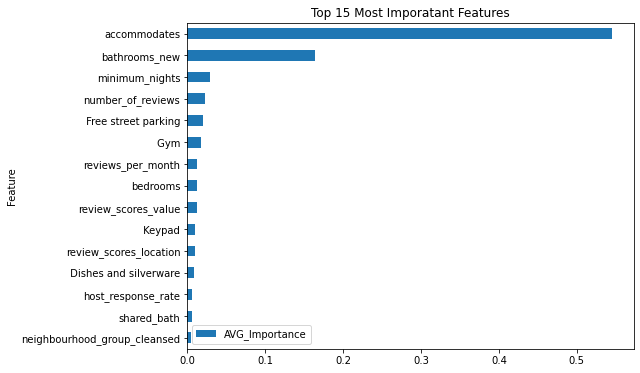

In [136]:
# feature importance
r_feature_importance[:15].sort_values(by='AVG_Importance').plot(kind='barh', x='Feature', y='AVG_Importance', figsize=(8,6));
plt.title('Top 15 Most Imporatant Features');

#### Conclusions

1. Manchester town has the most listings in the Greater Manchester Area, accounting for 53% of total listings followed by Salford with 17% and Trafford with about 9% of total listings.


2. Amongst the top 10 most reviewed property types by customers, "Entire Cottage" had the highest median rating of 4.9 followed by entire bungalow, tiny home, private room in a residential home and private room in a townhouse.


3. 65.4% of total listings were priced between $0–$100 while $100–$200 priced listings accounted for 23.4% of total listings.


4. The bulk of the property listings were entire homes/apartments. The 'entire rooms' accounted for about 60% of total listings followed by private rooms with 39% of listings.Shared rooms and hotel rooms accounted for 0.7% and 0.5% of listings respectively.


5. The RandomForestRegression algorithm performed best in predicting prices of listings in the Greater Manchester Area. The model achieved an root mean square error of 32.2 and an R^2 value of 59.3% which means that the features are able to explain 59% of the variability in price of the listings.  

#### Improvements

1. Better data engineering for amenities data can improve the overall performance of the model. 